# Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
device = torch.device('cuda')

In [3]:
#### from https://github.com/gngdb/pytorch-pca/tree/main ####
def svd_flip(u, v):
    # columns of u, rows of v
    max_abs_cols = torch.argmax(torch.abs(u), 0)
    i = torch.arange(u.shape[1]).to(u.device)
    signs = torch.sign(u[max_abs_cols, i])
    u *= signs
    v *= signs.view(-1, 1)
    return u, v

class TorchPCA(nn.Module):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components

    #@torch.no_grad()
    def fit(self, X):
        n, d = X.size()
        if self.n_components is not None:
            d = min(self.n_components, d)
        self.register_buffer("mean_", X.mean(0, keepdim=True))
        Z = X - self.mean_ # center
        U, S, Vh = torch.linalg.svd(Z, full_matrices=False)
        Vt = Vh
        U, Vt = svd_flip(U, Vt)
        self.register_buffer("components_", Vt[:d])
        return self

    def forward(self, X):
        return self.transform(X)

    def transform(self, X):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(X - self.mean_, self.components_.t())

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, Y):
        assert hasattr(self, "components_"), "PCA must be fit before use."
        return torch.matmul(Y, self.components_) + self.mean_

# Load data

In [4]:
X_A = pd.read_csv('../preprocessing/XA4Feaver.csv',index_col=0)
X_B = pd.read_csv('../preprocessing/X_feaver.csv',index_col=0)
Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)

In [5]:
# X_A = pd.read_csv('../preprocessing/X_A.csv',index_col=0)
# X_B = pd.read_csv('../preprocessing/X_B.csv',index_col=0)
# Y_A = pd.read_csv('../preprocessing/Y_A.csv',index_col=0)
# lean_control_chips = pd.read_csv('../preprocessing/chip_lean_controls_indices.csv',index_col=0)
# fatty_control_chips = pd.read_csv('../preprocessing/chip_fatty_controls_indices.csv',index_col=0)

In [6]:
# get total variance of X_A
varA = np.var(X_A,axis=0).sum()
print(varA)

252.34743171729244


# Get PCA loadings

In [7]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X_B)
# transform your data into PCA space
Z_B = pca.transform(X_B)

Text(0.5, 1.0, 'in-vitro model PC space')

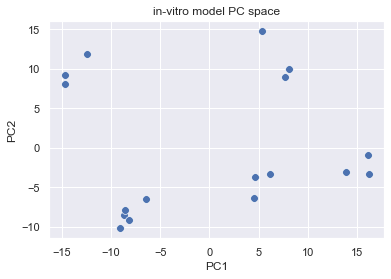

In [8]:
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# pca_data = pd.concat([pca_data,pd.DataFrame(data={'PC1':Z_A_B[:,0], 'PC2':Z_A_B[:,1]})])
# pca_data['dataset'] = ['in-vitro model' for i in range(Z_B.shape[0])] + ['humans' for i in range(Z_A_B.shape[0])]
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2', s =60 , palette= 'icefire')
plt.title('in-vitro model PC space')

In [9]:
loadings = pca.components_
print(loadings.shape)

(17, 33627)


In [10]:
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

The explained variance of the human data in the PC-space of liver chip is 9.81 %


In [11]:
original_explained = 100*varAB/varA

# Initialize perturbation as a small random dX

In [12]:
XB = torch.tensor(X_B.values).float().to(device)
XA = torch.tensor(X_A.values).float().to(device)

Sample 0 Iteration=0, loss=-0.0977, explained_variance=9.95%
Sample 0 Iteration=200, loss=-0.2356, explained_variance=23.76%
Sample 0 Iteration=400, loss=-0.2352, explained_variance=23.77%
Sample 0 Iteration=600, loss=-0.2299, explained_variance=23.74%
Sample 0 Iteration=800, loss=-0.2340, explained_variance=23.76%
Sample 0 Iteration=999, loss=-0.2282, explained_variance=23.62%
The new explained variance of the human data in the PC-space of liver chip is 23.34 %
Sample 1 Iteration=0, loss=-0.0977, explained_variance=9.95%
Sample 1 Iteration=200, loss=-0.2353, explained_variance=23.76%
Sample 1 Iteration=400, loss=-0.2358, explained_variance=23.76%
Sample 1 Iteration=600, loss=-0.2310, explained_variance=23.74%
Sample 1 Iteration=800, loss=-0.2353, explained_variance=23.77%
Sample 1 Iteration=999, loss=-0.2280, explained_variance=23.71%
The new explained variance of the human data in the PC-space of liver chip is 23.41 %
Sample 2 Iteration=0, loss=-0.0977, explained_variance=9.95%
Sampl

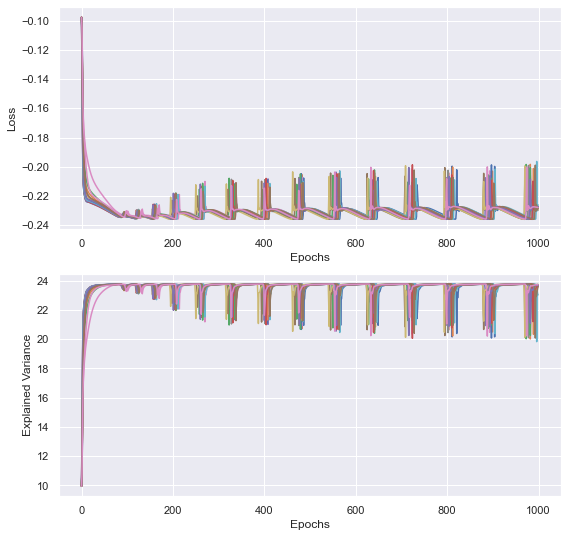

In [14]:
new_vars = []
df_pert = pd.DataFrame({})
fig, axs = plt.subplots(2,figsize=(9, 9))
for j in range(XB.shape[0]):
    XB_start = XB[j,:].view(1,XB.shape[1])
    #XB_start = torch.mean(XB,0,keepdim= True)
    dX = np.random.normal(X_B.mean(0).values,X_B.std(0).values,size=(1,X_B.shape[1]))
    dX = torch.tensor(dX).float().to(device)
    Input_pert = torch.nn.Parameter(dX, requires_grad = True)
    Input_pert.retain_grad()
    optimizer = torch.optim.Adam([Input_pert],lr= 0.1,weight_decay=0)


    loss_all = []
    exp_var_all = []
    iters = 1000
    torch.autograd.set_detect_anomaly(True)
    #j=0
    for i in range(iters):
        optimizer.zero_grad()
        Xstar = XB_start + Input_pert
        X = torch.concat((XB,Xstar),0)
        U,S,V = torch.svd(X)
        Z_A_B = torch.matmul(XA,V)
        varAB = torch.var(Z_A_B,axis=0).sum()

        loss = - varAB/varA
        loss = loss + 1e-6 * torch.sum(torch.abs(Input_pert))
        loss.backward()
        optimizer.step()

        exp_var = 100 * varAB/varA
        exp_var = exp_var.item()
        loss_all.append(loss.item())
        exp_var_all.append(exp_var)
        if i % 200 == 0 :
            outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
            outString += ', loss={:.4f}'.format(loss.item())
            outString += ', explained_variance={:.2f}%'.format(exp_var)
            print(outString)
    outString = 'Sample {:.0f} Iteration={:.0f}'.format(j,i)
    outString += ', loss={:.4f}'.format(loss.item())
    outString += ', explained_variance={:.2f}%'.format(exp_var)
    print(outString)
    dx = pd.DataFrame(Input_pert.detach().cpu().numpy())
    dx.columns = X_B.columns.values
    df_pert = df_pert.append(dx)
    axs[0].plot(range(iters),loss_all)
    axs[1].plot(range(iters),exp_var_all)
    axs[0].set(xlabel='Epochs', ylabel='Loss')
    axs[1].set(xlabel='Epochs', ylabel='Explained Variance')
    #plt.plot(range(iters),exp_var_all)
    
    Xstar = XB_start + Input_pert
    X = torch.concat((XB,Xstar),0)
    X = X.detach().cpu().numpy()
    # initialize a PCA object with the largest value of n_components you can
    pca = PCA()
    # fit your PCA object to your data
    pca.fit(X)
    loadings = pca.components_
    Z_A_B = np.dot(X_A,loadings.T)
    varAB = np.var(Z_A_B,axis=0).sum()
    print('The new explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))
    new_vars.append(100*varAB/varA)

In [15]:
df_pert.index = [i for i in range(XB.shape[0])]

In [16]:
df_pert

,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,...,RNA5SP334,ELP5,GALNT9,MIR23AHG,DDX51,YBX2,C1R,PRKACA,CTAGE4,CTAGE8
0,-0.435747,-0.352894,-1.126708,-0.259129,-0.703282,-0.118943,-0.599071,-0.368007,-0.393791,-0.480711,...,-0.284160,0.398335,-0.087560,-0.516068,-0.101083,0.091937,-0.727908,0.119387,0.246500,-1.399154
1,0.473595,0.424755,1.209749,0.254198,0.806413,0.109705,0.630394,0.418273,0.424069,0.515287,...,0.331885,-0.395906,0.081588,0.545657,0.134952,-0.053393,0.809553,-0.107527,-0.158980,1.688670
2,-0.472145,-0.391756,-1.174416,-0.256138,-0.755220,-0.106961,-0.619604,-0.393122,-0.433294,-0.471132,...,-0.331538,0.382426,-0.076259,-0.524314,-0.101042,0.065604,-0.785529,0.102822,0.168020,-1.481681
3,-0.506264,-0.439521,-1.279549,-0.244830,-0.824812,-0.126635,-0.643100,-0.407108,-0.399252,-0.526602,...,-0.326686,0.403961,-0.036522,-0.551250,-0.158296,0.046332,-0.821091,0.117831,0.192042,-1.784459
4,-0.457695,-0.378187,-1.167433,-0.215861,-0.738765,-0.112968,-0.600358,-0.380953,-0.375676,-0.475360,...,-0.325211,0.394214,-0.076620,-0.506981,-0.100959,0.070856,-0.778471,0.112429,0.181455,-1.520811
5,-0.612228,-0.427335,-1.329975,-0.160391,-0.803962,-0.081444,-0.591384,-0.444788,-0.350679,-0.519403,...,-0.367723,0.421053,-0.074123,-0.543254,-0.118330,0.074249,-0.843232,0.121025,0.161747,-1.790197
6,0.506608,0.436856,1.291770,0.286609,0.832736,0.135647,0.654715,0.418791,0.447512,0.530250,...,0.354657,-0.395372,0.086304,0.580802,0.139063,-0.024073,0.863934,-0.107919,-0.175551,1.828844
7,0.573685,0.426583,1.260088,0.204704,0.774647,0.081686,0.598941,0.424687,0.385042,0.526371,...,0.367889,-0.398278,0.068951,0.516684,0.145979,-0.057049,0.814874,-0.119858,-0.158623,1.704622
8,-0.477297,-0.365264,-1.148413,-0.229433,-0.723891,-0.107059,-0.579759,-0.366046,-0.352883,-0.441180,...,-0.320783,0.400649,-0.075591,-0.500568,-0.104696,0.070130,-0.751977,0.104397,0.183257,-1.492845
9,0.243313,0.093455,0.586793,0.199136,0.419019,0.148753,0.425542,0.190737,0.211708,0.221638,...,0.181058,-0.290566,0.035907,0.199927,-0.068457,-0.014058,0.409363,-0.147147,-0.425037,0.711680


In [17]:
df_pert.to_csv('../results/optimized_mps/dx_feaver.csv')

In [18]:
df_results = pd.DataFrame({'orginal_var_exp':np.repeat(original_explained,len(new_vars)),
                           'new_var_exp':np.array(new_vars),
                           'dataset':np.repeat('Feaver',len(new_vars))})
df_results

,orginal_var_exp,new_var_exp,dataset
0,9.8098,23.338007,Feaver
1,9.8098,23.405145,Feaver
2,9.8098,23.421521,Feaver
3,9.8098,23.400137,Feaver
4,9.8098,23.426204,Feaver
5,9.8098,23.421778,Feaver
6,9.8098,23.414677,Feaver
7,9.8098,23.412207,Feaver
8,9.8098,23.428814,Feaver
9,9.8098,22.902337,Feaver


In [19]:
df_results.to_csv('../results/optimized_mps/optimized_results_feaver.csv')

### Validate with sklearn

In [20]:
Xstar = XB + torch.tensor(df_pert.values).to(device)
X = torch.concat((XB,Xstar),0)
X = X.detach().cpu().numpy()

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

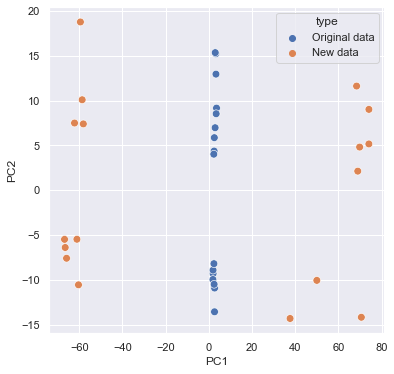

In [21]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(X)
# transform your data into PCA space
Z_B = pca.transform(X)
pca_data = pd.DataFrame(data={'PC1':Z_B[:,0], 'PC2':Z_B[:,1]})
# plot our PCA transformed data using sns.scatterplot() (set hue = target)
pca_data["type"] = ['Original data' for i in range(XB.shape[0])] + ['New data' for i in range(XB.shape[0])]
plt.figure(figsize=(6, 6))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 ,hue='type')

In [22]:
loadings = pca.components_
print(loadings.shape)
Z_A_B = np.dot(X_A,loadings.T)
varAB = np.var(Z_A_B,axis=0).sum()
print('The explained variance of the human data in the PC-space of liver chip is {:.2f} %'.format(100*varAB/varA))

(34, 33627)
The explained variance of the human data in the PC-space of liver chip is 25.28 %


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

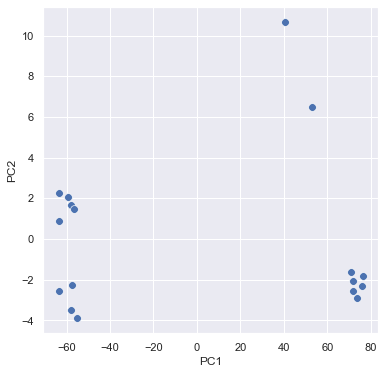

In [23]:
# initialize a PCA object with the largest value of n_components you can
pca = PCA()
# fit your PCA object to your data
pca.fit(df_pert.values)
# transform your data into PCA space
Z = pca.transform(df_pert.values)
pca_data = pd.DataFrame(data={'PC1':Z[:,0], 'PC2':Z[:,1]})
plt.figure(figsize=(6, 6))
sns.scatterplot(data = pca_data , x = 'PC1',y = 'PC2' , s =60 )